In [28]:
import scipy.io
import os
import re
import glob
import importlib

import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns

import utils as util
import plotting as plotutils

In [15]:
rootdir = '/mnt/sda/Videos'
assay_prefix='single_20mm'
#sessionid = '20220128-1555'
sessionid = '20220203-0951'

In [19]:
importlib.reload(util)

<module 'utils' from '/home/julianarhee/Repositories/flytracker/utils.py'>

In [17]:
acq_dir = util.get_acq_dir(sessionid, assay_prefix=assay_prefix)
acquisition = os.path.split(acq_dir)[-1]
print('Processing acq: %s' % acquisition)

Processing acq: 20220203-0951_sant_3do_sh


# Load FlyTracker output

In [20]:
#%% Get corresponding calibration file
calib = util.load_calibration(acq_dir)

#% Load feature mat
featdf = util.load_feat(acq_dir)
trackdf = util.load_tracks(acq_dir)

trackdf = util.add_frame_nums(trackdf, fps=calib['FPS'])
featdf = util.add_frame_nums(featdf, fps=calib['FPS'])

calib

{'n_chambers': 1,
 'n_rows': 1,
 'n_cols': 1,
 'FPS': 60,
 'PPM': 60.88519269776877,
 'centroids': array([768, 768], dtype=uint16),
 'w': 1496,
 'h': 1496,
 'rois': array([ 130,  123, 1256, 1253], dtype=uint16),
 'n_flies': 2,
 'cop_ind': 7085}

# Set output dir

In [13]:
project_dir = '/home/julianarhee/Documents/projects'
dst_dir = os.path.join(project_dir, 'flytracker-analysis', 'examples')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print("Saving output to: %s" % dst_dir )

Saving output to: /home/julianarhee/Documents/projects/flytracker-analysis/examples


# 1 fly

In [24]:
ppm = calib['PPM']
fps = calib['FPS']
cop_ind = calib['cop_ind']
male_id=0
female_id=1

# interaction params:
interaction_dist_mm = 5
max_dist_to_other = interaction_dist_mm #* ppm
max_facing_angle=80
# -----------------------------------------

In [25]:
fly_id = 0
feat = featdf[featdf['id']==fly_id].copy()
trk = trackdf[trackdf['id']==fly_id].copy()

In [31]:
feat = util.threshold_courtship_bouts(feat, max_dist_to_other=max_dist_to_other, max_facing_angle=max_facing_angle)
feat.columns

ibi_min_sec=5
feat, bout_dict = util.get_true_bouts(feat, calib, ibi_min_sec=ibi_min_sec)
print("Found %i bouts, with min. IBI=%.2f sec" % (len(bout_dict), ibi_min_sec))

bouts = [b for i, b in bout_dict.items()]

Found 33 bouts, with min. IBI=5.00 sec


In [32]:
cdict = {'wing_r': 'mediumpurple',
        'wing_l': 'orchid'}

In [46]:
feat.loc[1259][['courtship', 'facing_angle_deg', 'dist_to_other']]

courtship               True
facing_angle_deg    1.011658
dist_to_other       2.260817
Name: 1259, dtype: object

In [107]:
sorted_by_len = sorted(bouts, key=len)

start_frame=6000
end_frame=6500

Current bout: 0.00min


KeyError: 'wing_r'

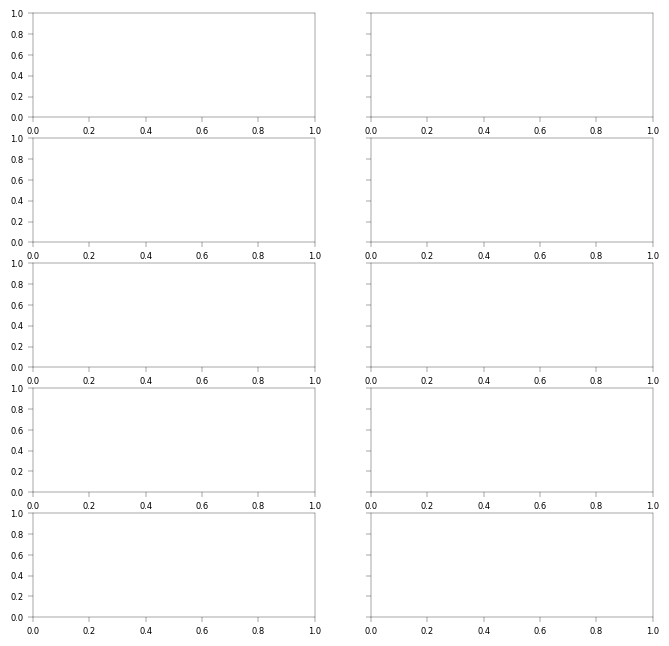

In [108]:

plotutils.set_plot_params(light=False) #lw_axes=1, axis_labelsize=12, tick_labelsize=10, color=[0.7]*3, dpi=300)

fig, axn = pl.subplots(5, 2, figsize=(8,8), sharey=True)

sorted_bouts = sorted(bouts, key=lambda x:x[0])

# for ai, curr_bout in enumerate(sorted_by_len[::-1]):
for ai, curr_bout in enumerate(sorted_bouts):
    bout_dur_sec = (curr_bout[-1]-curr_bout[0])/fps
    print("Current bout: %.2fmin" % (bout_dur_sec/60.) )
    start_frame, end_frame = curr_bout[0], curr_bout[-1]
    df_ = trk.loc[start_frame:end_frame]

    # plot
    ax = axn.flatten()[ai]
    ax.plot(np.rad2deg(df_['wing_r_ang']), color=cdict['wing_r'], label='wing_r')
    ax.plot(np.rad2deg(df_['wing_l_ang']), color=cdict['wing_l'], label='wing_l')
    ax.set_ylim([-100, 100])
    #ax.legend(bbox_to_anchor=(1,1), loc='upper right')


In [50]:
calib['FPS']


60

In [135]:
cdict = {'wing_r': 'mediumpurple',
        'wing_l': 'orchid'}

cdict = {'M': {'wing_l': 'mediumpurple',
               'wing_r': 'orchid'},
         'F': {'wing_r': 'aquamarine',
               'wing_l': 'cyan'}}

In [411]:
start_frame = calib['cop_ind'] - calib['FPS']*60*.5
end_frame = calib['cop_ind']

# start_frame=6050
# end_frame=6100

# start_frame=6400
# end_frame=6490

start_frame=5600
end_frame=5700

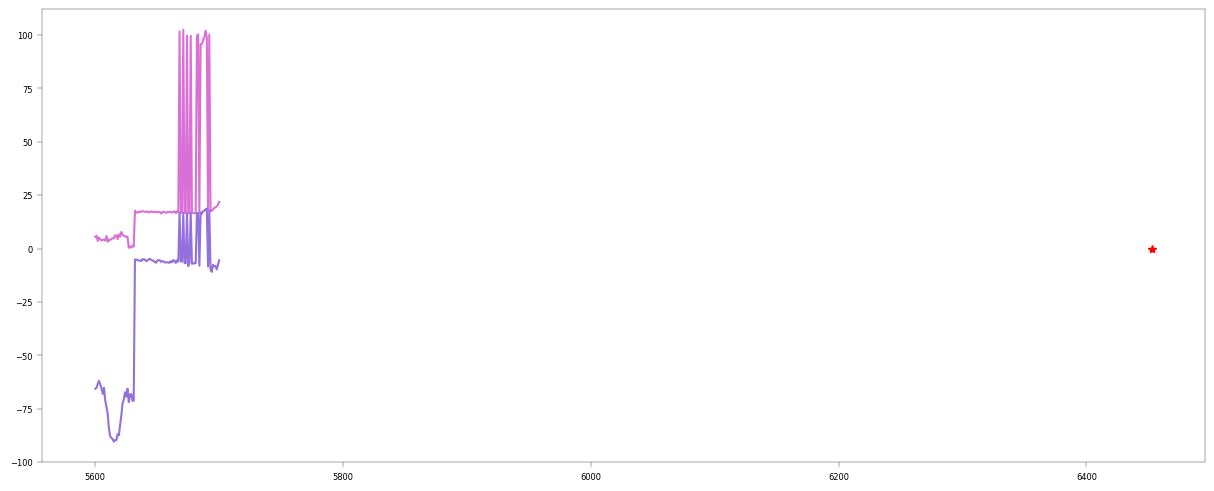

In [412]:
trkM = trackdf[trackdf['id']==0].copy()

trkF = trackdf[trackdf['id']==1].copy()
trkF.index = trkF['frame']
fig, ax= pl.subplots(figsize=(15, 6))
ax.patch.set_alpha(0)

offset=0
# ax.plot(np.rad2deg(trkF.loc[start_frame:end_frame]['wing_r_ang'])+offset, color=cdict['F']['wing_r'], label='wing_r')
# ax.plot(np.rad2deg(trkF.loc[start_frame:end_frame]['wing_l_ang'])+offset, color=cdict['F']['wing_l'], label='wing_l')
trkM['wing_r_ang'] = trkM['wing_r_ang'].interpolate()
trkM['wing_l_ang'] = trkM['wing_l_ang'].interpolate()

ax.plot(np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'])+offset*2, color=cdict['M']['wing_r'], label='wing_r')
ax.plot(np.rad2deg(trkM.loc[start_frame:end_frame]['wing_l_ang'])+offset*2, color=cdict['M']['wing_l'], label='wing_l')
ax.plot(6453, 0, 'r*')
#ax.set_ylim([-100, 100])

In [413]:
def consecutive(data, stepsize=1):
    #return np.split(data, np.where((np.diff(data)) >= stepsize)[0]+1)
    return np.split(data, np.where(np.diff(data) >= stepsize)[0]+1)


In [414]:

def fix_jumps(w_, stepsize=60, sign=1):

    grouped = consecutive(w_, stepsize=-stepsize)
    assert max(np.unique([len([gg for gg in g if not np.isnan(gg)]) for g in grouped]))<=2

    ww_=w_.copy()
    while max(np.diff([wg[0] for wg in grouped]))>(stepsize):
        ix=0
        new_g = []
        for i, g in enumerate(grouped):
            if len(g)==1:
                new_g.extend(g)
            else:
                if len(g)==2:
                    jump_v, next_v = g
                else:
                    jump_v = g[0]
                # Interpolate between last good val and next one (skip over the jump)
                ww_[ix] = np.nan
            ix+=len(g)
        new_ = pd.Series(ww_).interpolate()
        grouped = consecutive(new_.values, stepsize=-stepsize)
    return ww_

In [482]:
w_ = np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'].copy().values)
stepsize=14

#funk_ixs = [i+1 for i in np.where(np.diff(w_)>stepsize)[0]]
#w_[funk_ixs] = np.nan
#w_ = pd.Series(w_).interpolate().values

grouped = consecutive(w_, stepsize=-stepsize)
assert max(np.unique([len([gg for gg in g if not np.isnan(gg)]) for g in grouped]))<=2
ww_ = w_.copy()
#while max(np.diff([wg[0] for wg in grouped]))>stepsize:
new_g = ww_.copy()
ix = 0
for i, g in enumerate(grouped):
    if len(g)>1:
        # Interpolate between last good val and next one (skip over the jump)
        #g[0] = np.nan
        new_g[ix] = np.nan #.extend(g)
        #new_g[ix] = np.nan
    ix+=len(g)
ww_ = pd.Series(new_g).interpolate().values
grouped = consecutive(ww_, stepsize=-stepsize)

In [484]:
w_ = np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'].copy().values)
stepsize=15

#funk_ixs = [i+1 for i in np.where(np.diff(w_)>stepsize)[0]]
#w_[funk_ixs] = np.nan
#w_ = pd.Series(w_).interpolate().values

grouped = consecutive(w_, stepsize=stepsize)
grouped

[array([5.51449916, 6.03056597, 3.55892573, 5.1137643 , 4.35510296,
        3.805437  , 4.12108907, 4.23110051, 3.74932875, 5.90846787,
        3.23544442, 4.21451968, 4.0066494 , 4.54772777, 4.87051959,
        4.74320293, 6.26046032, 6.13075438, 4.48560263, 6.66483722,
        5.58521819, 7.81656071, 6.42783707, 6.03344634, 5.72773761,
        5.65777854, 5.62431209, 0.35512472, 1.00885682, 0.48275054,
        1.39988697, 0.94633082]),
 array([17.73318335, 16.9249078 , 16.80033762, 17.38017485, 17.2346921 ,
        17.17757376, 17.5563571 , 17.43302552, 17.17201626, 17.32511832,
        17.42832971, 16.91941066, 17.2585787 , 17.40679185, 17.05504081,
        17.2732521 , 17.26270015, 16.93367137, 17.17961077, 17.11677003,
        17.17747627, 16.55112819, 16.83694491, 17.3653747 , 17.01914507,
        16.79242478, 17.08395594, 17.10104369, 17.16800214, 17.17200482,
        16.88492306, 17.18328967, 17.45821444, 16.66939779, 17.48084955,
        16.9193365 ]),
 array([101.70574648,  1

In [467]:
new_g = ww_.copy()
ix = 0
for i, g in enumerate(grouped):
    if len(g)>1:
        # Interpolate between last good val and next one (skip over the jump)
        #g[0] = np.nan
        new_g[ix] = np.nan #.extend(g)
        #new_g[ix] = np.nan
    ix+=len(g)
ww_ = pd.Series(new_g).interpolate().values
grouped2 = consecutive(ww_, stepsize=-stepsize)

In [471]:
w_ = np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'].copy().values)
stepsize=10

funk_ixs = [i+1 for i in np.where(np.diff(w_)>stepsize)[0]]
w_[funk_ixs] = np.nan
w_

array([  5.51449916,   6.03056597,   3.55892573,   5.1137643 ,
         4.35510296,   3.805437  ,   4.12108907,   4.23110051,
         3.74932875,   5.90846787,   3.23544442,   4.21451968,
         4.0066494 ,   4.54772777,   4.87051959,   4.74320293,
         6.26046032,   6.13075438,   4.48560263,   6.66483722,
         5.58521819,   7.81656071,   6.42783707,   6.03344634,
         5.72773761,   5.65777854,   5.62431209,   0.35512472,
         1.00885682,   0.48275054,   1.39988697,   0.94633082,
                nan,  16.9249078 ,  16.80033762,  17.38017485,
        17.2346921 ,  17.17757376,  17.5563571 ,  17.43302552,
        17.17201626,  17.32511832,  17.42832971,  16.91941066,
        17.2585787 ,  17.40679185,  17.05504081,  17.2732521 ,
        17.26270015,  16.93367137,  17.17961077,  17.11677003,
        17.17747627,  16.55112819,  16.83694491,  17.3653747 ,
        17.01914507,  16.79242478,  17.08395594,  17.10104369,
        17.16800214,  17.17200482,  16.88492306,  17.18

In [472]:
np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'].copy().values)

array([  5.51449916,   6.03056597,   3.55892573,   5.1137643 ,
         4.35510296,   3.805437  ,   4.12108907,   4.23110051,
         3.74932875,   5.90846787,   3.23544442,   4.21451968,
         4.0066494 ,   4.54772777,   4.87051959,   4.74320293,
         6.26046032,   6.13075438,   4.48560263,   6.66483722,
         5.58521819,   7.81656071,   6.42783707,   6.03344634,
         5.72773761,   5.65777854,   5.62431209,   0.35512472,
         1.00885682,   0.48275054,   1.39988697,   0.94633082,
        17.73318335,  16.9249078 ,  16.80033762,  17.38017485,
        17.2346921 ,  17.17757376,  17.5563571 ,  17.43302552,
        17.17201626,  17.32511832,  17.42832971,  16.91941066,
        17.2585787 ,  17.40679185,  17.05504081,  17.2732521 ,
        17.26270015,  16.93367137,  17.17961077,  17.11677003,
        17.17747627,  16.55112819,  16.83694491,  17.3653747 ,
        17.01914507,  16.79242478,  17.08395594,  17.10104369,
        17.16800214,  17.17200482,  16.88492306,  17.18

In [446]:
w_ = np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'].copy().values)
stepsize=10
grouped = consecutive(w_, stepsize=-stepsize)

In [450]:
ww_

,0
0,5.514499
1,6.030566
2,3.558926
3,5.113764
4,4.355103
...,...
96,19.026392
97,19.381395
98,19.777537
99,20.572919


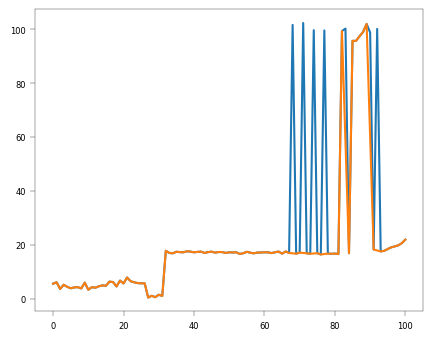

In [427]:
pl.figure()
pl.plot(w_)
pl.plot(ww_)


In [368]:
stepsize=60
r_ = np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'].values)
rr_ = fix_jumps(w_, stepsize=stepsize)

l_ = np.rad2deg(trkM.loc[start_frame:end_frame]['wing_l_ang'].values)
ll_ = fix_jumps(l_, stepsize=stepsize, sign=1)


KeyboardInterrupt: 

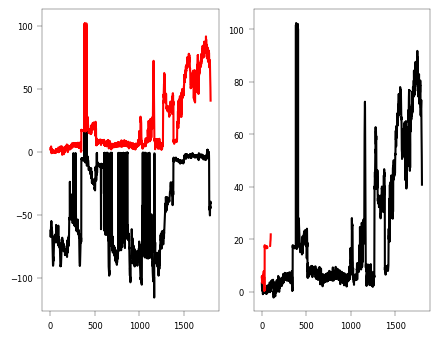

In [371]:
#w_ = np.rad2deg(trkM.loc[start_frame:end_frame]['wing_l_ang'].values)
# ix = np.where(np.abs(np.diff(np.rad2deg(trkM.loc[start_frame:end_frame]['wing_l_ang'])))>60)[0]
# w_[ix] = np.nan

fig, axn = pl.subplots(1,2)
#pl.plot(w_)
axn[0].plot(np.rad2deg(trkM.loc[start_frame:end_frame]['wing_l_ang'].values), 'k')
axn[0].plot(w_, 'r')

axn[1].plot(np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'].values), 'k')
axn[1].plot(rr_, 'r')
#pl.plot(np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'].values))
                    


In [ ]:
pl.figure()
pl.plot(np.diff(np.rad2deg(trkM.loc[start_frame:end_frame]['wing_l_ang'])))

pl.plot(np.diff(np.rad2deg(trkM.loc[start_frame:end_frame]['wing_r_ang'])))

In [61]:
start_frame

3485

In [62]:
end_frame

7085

In [65]:
trk.index = trk['frame']

In [66]:
trk

,pos_x,pos_y,ori,major_axis_len,minor_axis_len,body_area,fg_area,img_contrast,min_fg_dist,wing_l_x,...,leg_1_ang,leg_2_ang,leg_3_ang,leg_4_ang,leg_5_ang,leg_6_ang,id,fpath,frame,sec
frame,,,,,,,,,,,,,,,,,,,,,
0,1248.206635,731.921292,-0.547973,112.712404,53.350349,4612.0,11483.0,0.153241,748.657471,1167.0,...,-2.666594,-2.357944,-1.602993,-0.736836,1.974389,2.943808,1,/mnt/sda/Videos/single_20mm_1x1/20220203-0951_...,0,0.0
1,1248.467975,732.792754,-0.538186,112.550175,53.558766,4637.0,11452.0,0.150636,748.657471,1167.0,...,-2.624758,-2.356514,-1.604847,-0.758138,1.970682,2.956512,1,/mnt/sda/Videos/single_20mm_1x1/20220203-0951_...,1,0.016667
2,1248.646443,733.491270,-0.535010,111.961618,53.368481,4582.0,11437.0,0.154202,740.149292,1169.0,...,-2.651071,-2.323625,-1.592419,-0.761524,1.960018,2.941177,1,/mnt/sda/Videos/single_20mm_1x1/20220203-0951_...,2,0.033333
3,1249.037915,734.177941,-0.539174,112.423550,53.673605,4642.0,11443.0,0.149278,746.311584,1170.0,...,-2.634966,-2.337175,-1.580365,-0.740342,1.969174,2.948349,1,/mnt/sda/Videos/single_20mm_1x1/20220203-0951_...,3,0.05
4,1249.335612,736.302315,-0.552090,110.772306,53.264438,4535.0,11506.0,0.143460,738.033203,1170.0,...,-2.645755,-1.561813,-0.731212,1.973556,2.995978,NaN,1,/mnt/sda/Videos/single_20mm_1x1/20220203-0951_...,4,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73653,637.639378,611.217818,-2.201868,141.097389,51.104783,5399.0,23093.0,0.195372,0.000000,736.0,...,-2.812091,-2.419655,-2.242183,-1.621774,1.502696,2.924104,1,/mnt/sda/Videos/single_20mm_1x1/20220203-0951_...,73653,1227.55
73654,637.345919,610.963169,-2.205916,141.154744,51.238503,5403.0,13257.0,0.193670,15.132746,736.0,...,-2.803383,-2.411131,-2.241810,-1.618125,1.506844,2.924592,1,/mnt/sda/Videos/single_20mm_1x1/20220203-0951_...,73654,1227.566667
73655,637.280125,611.178815,-2.208358,141.548049,51.162522,5419.0,13204.0,0.195719,20.223749,736.0,...,-2.813451,-2.392446,-2.274545,-1.629330,1.505866,2.925496,1,/mnt/sda/Videos/single_20mm_1x1/20220203-0951_...,73655,1227.583333
